In [99]:
# import necessary packages
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm import tqdm

import pprint
import hdbscan
#import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

pp = pprint.PrettyPrinter(depth=4)
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)

In [82]:
# ?
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [83]:
# ?
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-12 16:41:49,548 - capstone.utils.utils - INFO - func:clean took: 5.78 sec
2022-12-12 16:41:52,759 - capstone.utils.utils - INFO - func:fit took: 8.99 sec
2022-12-12 16:41:59,525 - capstone.utils.utils - INFO - func:clean took: 6.76 sec
2022-12-12 16:42:03,872 - capstone.utils.utils - INFO - func:transform took: 11.11 sec
2022-12-12 16:42:03,875 - capstone.utils.utils - INFO - func:fit_transform took: 20.11 sec
2022-12-12 16:42:05,112 - capstone.utils.utils - INFO - func:clean took: 1.23 sec
2022-12-12 16:42:05,163 - capstone.utils.utils - INFO - func:transform took: 1.28 sec
2022-12-12 16:42:05,245 - capstone.utils.utils - INFO - func:build took: 21.61 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [84]:
# Reduce the dataset to contain only those regulation
# that map to a single quality topic
# Problem reduces to multi-class classification
df_features = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
df_features.reset_index(drop=True, inplace=True)

In [85]:
# load data from pickle file containing davinci embeddings
davinci_embeddings = pd.read_pickle(os.path.join(data.data_path, "davinci-embeddings.pkl"))
davinci_embeddings = pd.DataFrame(davinci_embeddings.items(), columns=[ORIGINAL_TEXT, "list_embeddings"])
davinci_embeddings[ORIGINAL_TEXT] = davinci_embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])
df_features = pd.merge(df_features, davinci_embeddings, on=ORIGINAL_TEXT,  how="inner")


In [86]:
# number of samples with single quality topic is 2787
davinci_embeddings.shape

(2787, 2)

In [87]:
# dimension of the davinci embeddings is 12288
len(davinci_embeddings['list_embeddings'][0])

12288

In [88]:
# all quality topics can be found in quality_topics
quality_topics = np.unique(df_features['Standard mapping?'])
quality_topics = [topic[0] for topic in quality_topics]

In [97]:
# get samples with selected quality topics 
keep_topics = {
    "udi and serialization",
    "vigilance",
    "qrb",
    "training",
    "samd",
    "audit inspection",
    "medical device post market surveillance",
    "controled substances"
}


for topic in keep_topics:
    assert topic in features.mlb.classes_

def ifkeep(target, keep_topics):
    for y in target:
        if y not in keep_topics:
            return False
    return True


e = df_features.copy()
e = e[e[TARGET].apply(ifkeep, keep_topics=keep_topics)].copy()
e.reset_index(drop=True, inplace=True)
embeddings = np.array(e["list_embeddings"].values.tolist())
y_true = e[features.mlb.classes_].to_numpy().argmax(axis=1).reshape(-1,)

e.shape

(447, 552)

In [90]:
# number of samples of selected topics
embeddings.shape

(704, 12288)

### Define utility functions

In [25]:
# Useful constants
CLUSTER = "cluster"
EMBEDDINGS = ["llm_{i}" for i in range(embeddings.shape[1])]
PCA_COMP = ["pca_1", "pca_2"]
TARGET_NUMERIC = "Target Numeric"

# Utility function to compute purity scores
def compute_purity(df):
    purity_scores = {}
    purity_scores_deep = {}
    clusters_unique = df[CLUSTER].unique()
    for c in clusters_unique:
        labels = df[df[CLUSTER]==c][TARGET_NUMERIC].tolist()
        sorted_labels = sorted(list(set(labels)), key=labels.count, reverse=True)
        mode = sorted_labels[0]
        if len(sorted_labels) > 1:
            mode2 = sorted_labels[1]
        else:
            mode2 = -1
        score = sum([1 if y==mode else 0 for y in labels]) / len(labels)
        score2 = sum([1 if y==mode2 else 0 for y in labels]) / len(labels)
        mode_label = features.mlb.classes_[mode]
        mode_label2 = features.mlb.classes_[mode2] if mode2 != -1 else -1
        purity_scores[c] = (score, mode_label)
        purity_scores_deep[c] = {mode_label: score, mode_label2: score2}
    return purity_scores, purity_scores_deep

# Utility function to find quality topics that did not win any cluster
def sanity_check(keep_topics, scores: dict()):
    counts = {}
    for c in scores:
        if scores[c][1] not in counts:
            counts[scores[c][1]] = 1
        else:
            counts[scores[c][1]] += 1
    missing = set(keep_topics) - set([c for c in counts])
    multiple = [(c, counts[c]) for c in counts if counts[c] > 1]
    return missing, multiple

### k-Means (Floyd)

In [13]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(keep_topics)//2, len(keep_topics)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


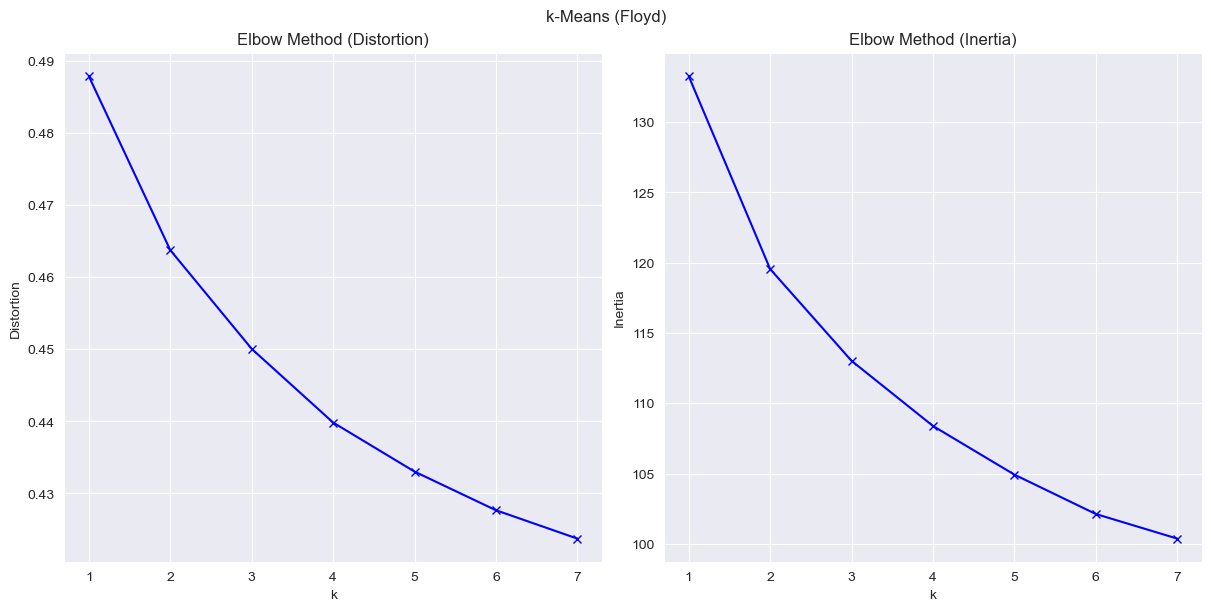

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Floyd)");

In [52]:
# set number of clusters to number of topics we selected
# use KMeans to cluster with full embeddings
k = len(keep_topics)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

# use PCA to reduce dimensions for visualization
dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

# add original text to embeddings_df and format the text properly for visualization
embeddings_df[ORIGINAL_TEXT] = e[ORIGINAL_TEXT]
embeddings_df[ORIGINAL_TEXT]= embeddings_df[ORIGINAL_TEXT].str.wrap(30)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].apply(lambda x: x.replace('\n', '<br>'))

scores, scores_deep = compute_purity(embeddings_df)
# get purity scores for each cluster
pp.pprint(scores)

{0: (0.29545454545454547, 'data management'),
 1: (0.47107438016528924, 'clinical research'),
 2: (0.9473684210526315, 'purchasing controls'),
 3: (0.9873417721518988, 'clinical research'),
 4: (0.4962962962962963, 'data management')}


In [92]:
# sort purity score by topic name alphabetically for eaiser comparison purpose
#{k: v for k, v in sorted(scores.items(), key=lambda item: item[1][1])}

In [93]:
# list missing topics and duplicate topics in the cliusters
# Missing topic: topics that are not majority topics in any of the clusters
# Duplicate topic: topics that are majority topics in more than one cluster
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'laboratory controls', 'udi and serialization'}


Multiple:
[('clinical research', 2), ('data management', 2)]


In [17]:
# get the top 2 majority topics in each cluster
pp.pprint(scores_deep)

{0: {'clinical research': 0.3829787234042553,
     'data management': 0.46808510638297873},
 1: {'data management': 0.3872549019607843,
     'purchasing controls': 0.6029411764705882},
 2: {'clinical research': 0.9852941176470589,
     'data management': 0.014705882352941176}}


In [95]:
# visualize clustering result with PCA 
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET,ORIGINAL_TEXT],
    title="k-Means & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [96]:
# visualize clustering result with TSNE

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/Users/gaoyihao/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/gaoyihao/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### k-means (Elkan) <br>

Repeat the same steps above with another algorithm of k-means

In [104]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

  0%|                                                                         | 0/7 [00:00<?, ?it/s]/Users/vishweshwartyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1325: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

100%|█████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.45s/it]


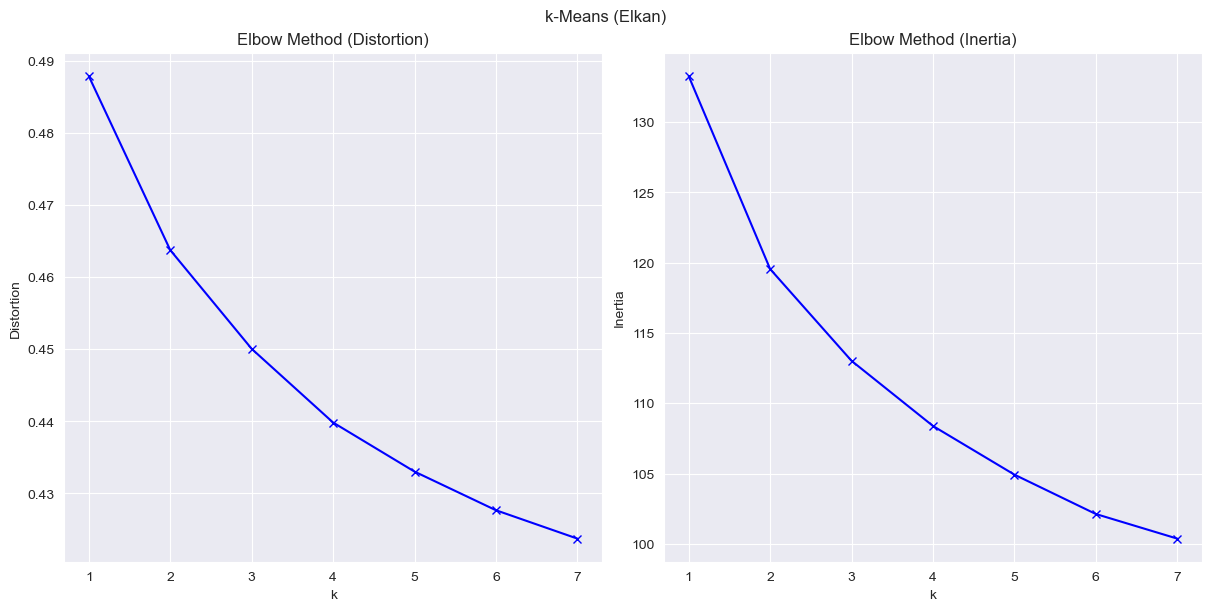

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Elkan)");

In [106]:
k = len(keep_topics)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.46808510638297873, 'data management'),
 1: (0.6029411764705882, 'purchasing controls'),
 2: (0.9852941176470589, 'clinical research')}


In [107]:
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
set()


Multiple:
[]


In [108]:
pp.pprint(scores_deep)

{0: {'clinical research': 0.3829787234042553,
     'data management': 0.46808510638297873},
 1: {'data management': 0.3872549019607843,
     'purchasing controls': 0.6029411764705882},
 2: {'clinical research': 0.9852941176470589,
     'data management': 0.014705882352941176}}


In [109]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

### Hierarchical Clustering (HDBSCAN)

This algorithm figures out the number of clusters on its own

In [100]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{-1: (0.15212527964205816, 'udi and serialization')}


Unclustered Samples

In [101]:
f"{sum(embeddings_df[CLUSTER] == -1) / len(embeddings_df) * 100:.3}%"

'1e+02%'

In [102]:
missing, multiple = sanity_check(keep_topics, scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'audit inspection',
 'controled substances',
 'medical device post market surveillance',
 'qrb',
 'samd',
 'training',
 'vigilance'}


Multiple:
[]


In [103]:
pp.pprint(scores_deep)

{-1: {'udi and serialization': 0.15212527964205816,
      'vigilance': 0.1476510067114094}}


In [104]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

In [105]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/Users/gaoyihao/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/gaoyihao/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

